In [32]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import umap
import pandas as pd
import numpy as np

from random import sample

from hitl_al_gomg.path import training, simulators, demos
from hitl_al_gomg.utils import ecfp_generator
from hitl_al_gomg.synthitl.simulated_expert import EvaluationModel, utility

from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

import matplotlib as mpl
import matplotlib.pyplot as plt

In [43]:
def set_matplotlib_params():

    """Set matplotlib params."""

    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams.update(
        {
            "font.size": 18,
            "lines.linewidth": 2,
            "axes.labelsize": 16,  # fontsize for x and y labels
            "axes.titlesize": 18,
            "xtick.labelsize": 16,
            "ytick.labelsize": 16,
            "legend.fontsize": 18,
            "axes.linewidth": 2,
            "text.usetex": False,  # use LaTeX to write all text
            "axes.spines.right": False,
            "axes.spines.top": False,
            "axes.spines.left": True,
            "axes.spines.bottom": True,
            "axes.grid": False,
        })

set_matplotlib_params()

In [15]:
scaffold_memory_initial = pd.read_csv(f"{demos}/demo_drd2_R4_step250_T5_n10_epig_noise0.15_seed4/iteration_0/scaffold_memory.csv", index_col = 0)
augmented_train_iter1 = pd.read_csv(f"{demos}/demo_drd2_R4_step250_T5_n10_epig_noise0.15_seed4/augmented_train_set_iter1.csv", index_col = 0)
initial_train_set = pd.read_csv(f"{training}/drd2_train.csv", index_col = 0)

In [16]:
#selected SMILES by EPIG, n_batch1
selected_smiles = augmented_train_iter1.SMILES.tolist()[130:140]

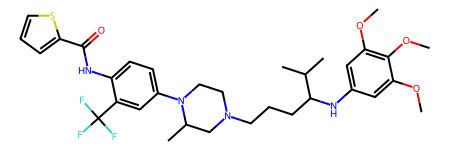

In [17]:
mol = Chem.MolFromSmiles(selected_smiles[4])
mol

In [18]:
selected_from_memory_indexes, not_selected_from_memory_indexes = [], []
for s in scaffold_memory_initial.SMILES.tolist():
    if s in selected_smiles:
        selected_from_memory_indexes.append(scaffold_memory_initial[scaffold_memory_initial["SMILES"] == s].index.item())
    else:
        not_selected_from_memory_indexes.append(scaffold_memory_initial[scaffold_memory_initial["SMILES"] == s].index.item())

In [19]:
sample_not_selected_from_memory_indexes = sample(not_selected_from_memory_indexes, 990)
sample_U = scaffold_memory_initial.iloc[
    selected_from_memory_indexes + sample_not_selected_from_memory_indexes
]

In [20]:
fp_counter = ecfp_generator(radius=3, useCounts=True)
fps = fp_counter.get_fingerprints(sample_U.SMILES.tolist())

In [34]:
is_pca = False

# Convert ECFP6 fingerprints to dataframe
ecfp_df = pd.DataFrame(fps.tolist(), index=sample_U.index)

if is_pca:
    # Apply PCA
    pca = PCA(n_components=2)
    result = pca.fit_transform(ecfp_df)
    minus_min, minus_max = 4, 2
else:
    # Apply UMAP
    result = umap.UMAP(n_components=2).fit_transform(ecfp_df)
    minus_min, minus_max = 4, 4

# Calculate kernel density estimate
kde = gaussian_kde(result.T)
xmin, ymin = result.min(axis=0) - minus_min
xmax, ymax = result.max(axis=0) + minus_max
X, Y = np.mgrid[xmin:xmax:250j, ymin:ymax:250j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

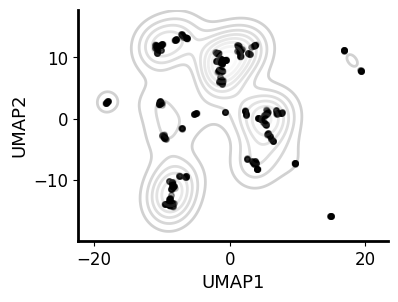

In [35]:
# Visualize all molecules in 2D with density background using KDE
plt.figure(figsize=(4, 3))
plt.contour(X, Y, Z, levels=10, cmap='gray', alpha=0.2)
plt.scatter(result[:, 0], result[:, 1], color='black', s=15, alpha=0.2)

plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.title(r'Molecules in $\mathcal{U}_r$')

# Remove upper and right frames
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

if is_pca:
    plt.xlabel('PC1', fontsize=13)
    plt.ylabel('PC2', fontsize=13)
else:
    plt.xlabel('UMAP1', fontsize=13)
    plt.ylabel('UMAP2', fontsize=13)
#plt.title(r'Molecules in $\mathcal{U}_r$')

plt.yticks(size=12)
plt.xticks(size=12)

#plt.ylim((-12, 16))

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

#plt.savefig('pca1.png', format='png')

plt.show()

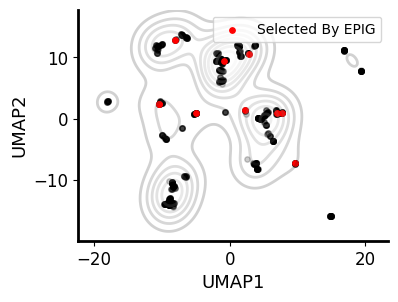

In [36]:
# Visualize all molecules in 2D with density background using KDE
plt.figure(figsize=(4, 3))
plt.contour(X, Y, Z, levels=10, cmap='gray', alpha=0.2)
not_subset_indices = [int(i) for i in sample_not_selected_from_memory_indexes]
plt.scatter(result[not_subset_indices, 0], result[not_subset_indices, 1], color='black', s=15, alpha=0.2)
# Color a subset of SMILES in red
subset_indices = [int(i) for i in selected_from_memory_indexes]
plt.scatter(result[subset_indices, 0], result[subset_indices, 1], color='red', s=15, label='Selected By EPIG')

plt.legend(fontsize=10)

if is_pca:
    plt.xlabel('PC1', fontsize=13)
    plt.ylabel('PC2', fontsize=13)
else:
    plt.xlabel('UMAP1', fontsize=13)
    plt.ylabel('UMAP2', fontsize=13)
#plt.title(r'Molecules in $\mathcal{U}_r$')

plt.yticks(size=12)
plt.xticks(size=12)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# Remove upper and right frames
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#plt.savefig('pca2.png', format='png')

plt.show()

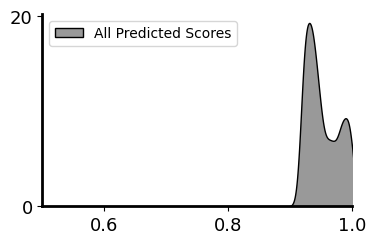

In [37]:
import seaborn as sns

plt.figure(figsize=(4, 2.5))

# Your list of values between 0 and 1
data = sample_U.raw_bioactivity.tolist()  # Your list of values here
sel_data = sample_U.iloc[selected_from_memory_indexes].raw_bioactivity.tolist()

# Plot KDE plot
sns.kdeplot(data, shade=True, color='black', alpha=0.4, label='All Predicted Scores')

#plt.xlabel('Predicted Score')
plt.ylabel(None)
plt.yticks(size=13)
plt.xticks(size=13)
#plt.title(r'Distribution of Predicted Scores in $\mathcal{U}_r$')
plt.legend(loc='upper left', fontsize=10)

# Remove upper and right frames
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlim((0.5,1))

#plt.savefig('pred_dist.png', format='png')

plt.show()

human score : 0.1293687859129411
human score : 0.2064932471842365
human score : 0.1771608232833718
human score : 0.0
human score : 0.19530585058297487
human score : 0.1283340828530353
human score : 0.14222194222386272
human score : 0.0
human score : 0.0
human score : 0.6008816427646112


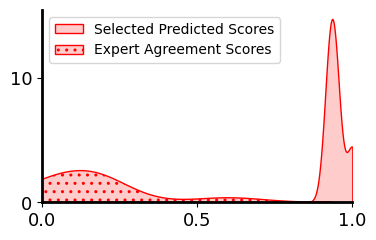

In [38]:
feedback_model = EvaluationModel("drd2", path_to_simulator=f"{simulators}/drd2.pkl")
human_scores = [feedback_model.human_score(s, 0.15) for s in selected_smiles]

plt.figure(figsize=(4, 2.5))

# Plot KDE plot
sns.kdeplot(sel_data, shade=True, color='red', alpha=0.2, clip=(0, 1), label='Selected Predicted Scores')
sns.kdeplot(human_scores, shade=True, color='red', alpha=0.2, hatch='..', clip=(0, 1), label='Expert Agreement Scores')
#plt.xlabel('Human Agreement Score')
plt.ylabel(None)
plt.yticks(size=13)
plt.xticks(size=13)
#plt.title(r'Distribution of Human Agreement Scores for $\mathcal{S}_T$')
plt.legend(loc='upper left', fontsize=10)

# Remove upper and right frames
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlim((0,1.))

#plt.savefig('expert_dist.png', format='png')

plt.show()

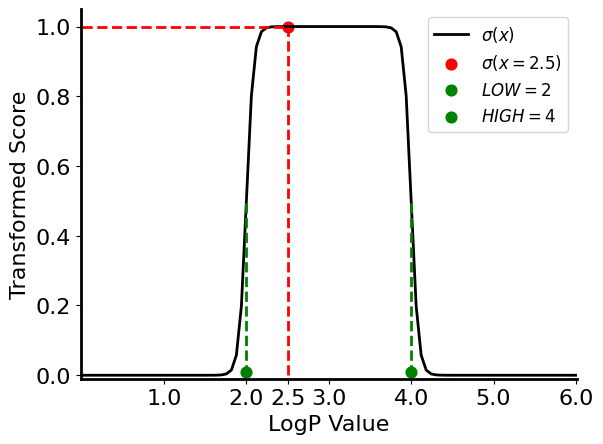

In [44]:
# Double sigmoid function

feedback_model = EvaluationModel("logp")

# Define the range of values
start = 0
stop = 6
num_values = 100  # Number of values to generate, including the endpoints

# Create a list of values ranging from -10 to 10
continuous_values = np.linspace(start, stop, num_values)

vals = [utility(x, 2, 4) for x in continuous_values]
val_at_2p5 = utility(2.5, 2, 4)

plt.plot(continuous_values, vals, color = "black", label = r"$\sigma(x)$")
plt.scatter([2.5], [val_at_2p5], marker="o", s=60, color="red", label = r"$\sigma(x = 2.5)$")
plt.scatter([2], [0.01], marker="o", s=60, color="green", label = r"$LOW=2$")
plt.scatter([4], [0.01], marker="o", s=60, color="green", label = r"$HIGH=4$")
plt.vlines(2.5, 0, 1, color="red", linestyle="--")
plt.hlines(val_at_2p5, 0, 2.5, color="red", linestyle="--")
plt.vlines(2, 0, 0.5, color="green", linestyle="--")
plt.vlines(4, 0, 0.5, color="green", linestyle="--")
plt.xlim(-0.01,6.01)
plt.ylim(-0.01,1.05)
plt.xticks([1,2,2.5,3,4,5,6])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel(r"LogP Value")
plt.ylabel(r"Transformed Score")
plt.legend(fontsize=12)

plt.show()